In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from DataLoader.Dataloader import HyperEdgeDataset
from DataLoader.Dataloader_directed import HyperDiEdgeDataset
from itertools import chain
import argparse
import pathlib
import os
from matplotlib import rc
# plt.rcParams.update({'font.size': 18})
plt.rcParams['text.usetex'] = True
resultpath ='nodeevent_directed/'
files = ['enron', 'eumail', 'hepth', 'arxiv', 'twitter']

In [75]:
## Created Custom Iterator For Getting Conn Probability from Text or CSV File
class Iterator:
    def __init__(self, filepath) -> None:
        if 'csv' == filepath[-3:]:
            self.file = pd.read_csv(filepath)
            self.cur_index = 0
            self.ftype = 'csv'
        else:
            with open(filepath,'r') as f:
                self.file = f.readlines()
            self.cur_index = 1
            self.ftype = 'txt'
        self.filesize = len(self.file)
        

    def getNext(self):
        self.cur_index +=1
        if self.ftype == 'csv':
            return (self.file['right_size'][self.cur_index - 1], self.file['left_size'][self.cur_index - 1] ,  self.file['MRR'][self.cur_index - 1],  self.file['mae'][self.cur_index - 1])
           
        else:
            cur_result = self.file[self.cur_index - 1].split(', ')
            return (int(cur_result[1].strip()), int(cur_result[2].strip()), float(cur_result[3].strip()), float(cur_result[5].strip()))

    def hasNext(self):
        return self.cur_index < self.filesize

In [76]:
def f(x):
    if x <= 2 :
        return 0
    if x < 5 :
        return 1
    if x < 9:
        return 2
    return 3
def get_size_ablation(iterator):
    mae, mrr = [[] for i in range(4)],[[] for i in range(4)]
    while iterator.hasNext():
        result = iterator.getNext()
        size = f(result[0] + result[1])
        mrr[size].append(result[2])
        mae[size].append(result[3])
    print([len(m)for m in mrr])
    mean_mrr = [np.mean(m) for m in mrr]
    mean_mae = [np.mean(m) for m in mae]
    print(f'mean mrr for size [0,1,2,3] is',mean_mrr )
    print(f'mean mae for size [0,1,2,3] is',mean_mae )
    return mean_mrr, mean_mae


# Enron

In [77]:
## Enron
arg ={}
arg['fileID'] = 0   ## Enter dataset ID here 
arg['onlyleft'] = True ## If only left side is consider in directed dataset
dataset = 'enron'
valid_folders = [files[arg['fileID']]+"_alpha0.3seed"+str(i) for i in range(4)] + [files[arg['fileID']]+"_dir_alpha0.3seed"+str(i) for i in range(4)]
subpath =  os.path.join(resultpath,files[arg['fileID']])
for folder in os.listdir(subpath):
    if folder in valid_folders:
        for file in os.listdir(os.path.join(subpath,folder)):
            if  file.endswith('test.csv') or file.endswith('test.txt'): arg[folder+'_test'] = file

In [78]:
mrr_undir , mrr_dir , mae_undir, mae_dir = [],[],[],[]
for seed in range(4):
    for folder in valid_folders:
        if 'seed'+str(seed) in folder:
            if 'dir' in folder:
                print(f'\n********************* Directed || Seed {seed} *****************************')
                test_iterator = Iterator(os.path.join(subpath,folder,arg[folder+"_test"]))
                result = get_size_ablation(test_iterator)
                mrr_dir.append(result[0])
                mae_dir.append(result[1])
            else:
                print(f'\n********************* Undirected || Seed {seed} *****************************')
                test_iterator = Iterator(os.path.join(subpath,folder,arg[folder+"_test"]))
                result = get_size_ablation(test_iterator)
                mrr_undir.append(result[0])
                mae_undir.append(result[1])



********************* Undirected || Seed 0 *****************************
[3099, 505, 188, 48]
mean mrr for size [0,1,2,3] is [0.6280983339703037, 0.5322571833313692, 0.5541690299683746, 0.3000167687423527]
mean mae for size [0,1,2,3] is [4.303252519552228, 3.7117090198644758, 3.8050741490689997, 1.0591606660357986]

********************* Directed || Seed 0 *****************************
[3099, 505, 188, 48]
mean mrr for size [0,1,2,3] is [0.5936817026373435, 0.6535094793627758, 0.7028034920705125, 0.5590231251747658]
mean mae for size [0,1,2,3] is [4.373772631915934, 3.7343199899291046, 3.8259561724485236, 1.04655852727592]

********************* Undirected || Seed 1 *****************************
[3099, 505, 188, 48]
mean mrr for size [0,1,2,3] is [0.6469223447199328, 0.541310858195371, 0.5866428952505613, 0.27702569620062906]
mean mae for size [0,1,2,3] is [4.282860420170658, 3.6954210997254835, 3.790252883680799, 1.0251775637734681]

********************* Directed || Seed 1 *********

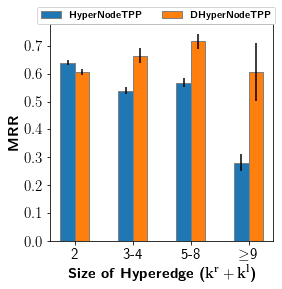

In [79]:
mrr_undir_mean, mrr_undir_std = np.mean(mrr_undir,axis =0) , np.std(mrr_undir, axis = 0)
mrr_dir_mean, mrr_dir_std = np.mean(mrr_dir,axis =0) , np.std(mrr_dir, axis = 0)
barWidth = 0.25
fig = plt.subplots(figsize =(4, 4))
x1 = np.arange(mrr_undir_mean.shape[0])
x2 = [x + barWidth for x in x1]
 
# Make the plot
plt.bar(x1, mrr_undir_mean, yerr= mrr_undir_std, width = barWidth,
        edgecolor ='grey', label =r'\textbf{HyperNodeTPP}')
plt.bar(x2, mrr_dir_mean, yerr= mrr_dir_std, width = barWidth,
        edgecolor ='grey', label =r'\textbf{DHyperNodeTPP}')

plt.xticks([r + barWidth/2 for r in range(len(x1))],
        [r'2', r'3-4', r'5-8', r'$\geq$9'], fontweight ='bold',fontsize = 15)
legend_properties = {'weight':'bold'}
plt.legend(prop=legend_properties, ncol = 2, loc=[-0.06,1])
plt.xlabel(r'\textbf{Size of Hyperedge ($\mathbf{k^r + k^l}$)}',fontsize = 15)
plt.ylabel(r'\textbf{MRR}',fontsize = 15)
plt.yticks(fontweight ='bold',fontsize = 15)
pathlib.Path(f"./Plots/{files[arg['fileID']]}").mkdir(parents=True,exist_ok=True)
plt.savefig(f"./Plots/{files[arg['fileID']]}/mrr.pdf",bbox_inches='tight', dpi = 1000, pad_inches=0)
plt.show()



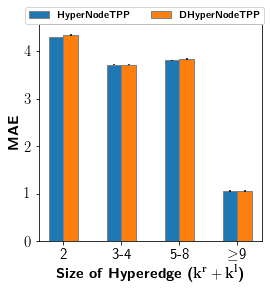

In [80]:
mae_undir_mean, mae_undir_std = np.mean(mae_undir,axis =0) , np.std(mae_undir, axis = 0)
mae_dir_mean, mae_dir_std = np.mean(mae_dir,axis =0) , np.std(mae_dir, axis = 0)

barWidth = 0.25
fig = plt.subplots(figsize =(4, 4))
x1 = np.arange(mae_undir_mean.shape[0])
x2 = [x + barWidth for x in x1]
 
# Make the plot
plt.bar(x1, mae_undir_mean, yerr= mae_undir_std, width = barWidth,
        edgecolor ='grey', label =r'\textbf{HyperNodeTPP}')
plt.bar(x2, mae_dir_mean, yerr= mae_dir_std, width = barWidth,
        edgecolor ='grey', label =r"\textbf{DHyperNodeTPP}")

# plt.xticks(np.array(x1)+barWidth/2, x1)
plt.xticks([r + barWidth/2 for r in range(len(x1))],
        [r'2', r'3-4', r'5-8', r'$\geq$9'], fontweight ='bold', fontsize = 15)
legend_properties = {'weight':'bold'}
plt.legend(prop=legend_properties, ncol = 2, loc=[-0.06,1])
plt.xlabel(r'\textbf{Size of Hyperedge ($\mathbf{k^r + k^l}$)}', fontsize = 15)
plt.ylabel(r'\textbf{MAE}', fontsize = 15)
plt.yticks(fontweight ='bold',fontsize= 15)
pathlib.Path(f"./Plots/{files[arg['fileID']]}").mkdir(parents=True,exist_ok=True)
plt.savefig(f"./Plots/{files[arg['fileID']]}/mae.pdf",bbox_inches='tight', dpi = 1000, pad_inches=0)
plt.show()

## Eumail

In [81]:
## eumail
arg ={}
arg['fileID'] = 1  ## Enter dataset ID here 
arg['onlyleft'] = True ## If only left side is consider in directed dataset
valid_folders = [files[arg['fileID']]+"_alpha0.1seed"+str(i) for i in range(3)] + [files[arg['fileID']]+"_dir_alpha0.1seed"+str(i) for i in range(3)]
subpath =  os.path.join(resultpath,files[arg['fileID']])
for folder in os.listdir(subpath):
    if folder in valid_folders:
        for file in os.listdir(os.path.join(subpath,folder)):
            if  file.endswith('test.csv') or file.endswith('test.txt'): arg[folder+'_test'] = file

In [82]:
mrr_undir , mrr_dir , mae_undir, mae_dir = [],[],[],[]
for seed in range(4):
    for folder in valid_folders:
        if 'seed'+str(seed) in folder:
            if 'dir' in folder:
                print(f'\n********************* Directed || Seed {seed} *****************************')
                test_iterator = Iterator(os.path.join(subpath,folder,arg[folder+"_test"]))
                result = get_size_ablation(test_iterator)
                mrr_dir.append(result[0])
                mae_dir.append(result[1])
            else:
                print(f'\n********************* Undirected || Seed {seed} *****************************')
                test_iterator = Iterator(os.path.join(subpath,folder,arg[folder+"_test"]))
                result = get_size_ablation(test_iterator)
                mrr_undir.append(result[0])
                mae_undir.append(result[1])



********************* Undirected || Seed 0 *****************************
[42649, 6419, 2322, 833]
mean mrr for size [0,1,2,3] is [0.7592043039830301, 0.7436017062858009, 0.7417115579334366, 0.622442863586427]
mean mae for size [0,1,2,3] is [3.2994813685419384, 76.61738765953594, 3.0595867085181543, 2.734608165995807]

********************* Directed || Seed 0 *****************************
[42649, 6419, 2322, 833]
mean mrr for size [0,1,2,3] is [0.6452272696838814, 0.8002104065960619, 0.8612740678194521, 0.8097710655141277]
mean mae for size [0,1,2,3] is [3.2545624126281956, 76.59909549068, 3.020159199878792, 2.6401655400643684]

********************* Undirected || Seed 1 *****************************
[42649, 6419, 2322, 833]
mean mrr for size [0,1,2,3] is [0.759593989917662, 0.7498828889803549, 0.7599989174352598, 0.6343231852359774]
mean mae for size [0,1,2,3] is [3.252073942054319, 76.61252692000745, 3.0813224768325442, 2.7412619154636455]

********************* Directed || Seed 1 **

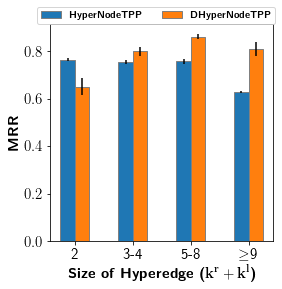

In [85]:
mrr_undir_mean, mrr_undir_std = np.mean(mrr_undir,axis =0) , np.std(mrr_undir, axis = 0)
mrr_dir_mean, mrr_dir_std = np.mean(mrr_dir,axis =0) , np.std(mrr_dir, axis = 0)
barWidth = 0.25
fig = plt.subplots(figsize =(4, 4))
x1 = np.arange(mrr_undir_mean.shape[0])
x2 = [x + barWidth for x in x1]
 
# Make the plot
plt.bar(x1, mrr_undir_mean, yerr= mrr_undir_std, width = barWidth,
        edgecolor ='grey', label =r'\textbf{HyperNodeTPP}')
plt.bar(x2, mrr_dir_mean, yerr= mrr_dir_std, width = barWidth,
        edgecolor ='grey', label =r'\textbf{DHyperNodeTPP}')

plt.xticks([r + barWidth/2 for r in range(len(x1))],
        [r'2', r'3-4', r'5-8', r'$\geq$9'], fontweight ='bold',fontsize = 15)
legend_properties = {'weight':'bold'}
plt.legend(prop=legend_properties, ncol = 2, loc=[-0.06,1])
plt.xlabel(r'\textbf{Size of Hyperedge ($\mathbf{k^r + k^l}$)}',fontsize = 15)
plt.ylabel(r'\textbf{MRR}',fontsize = 15)
plt.yticks(fontweight ='bold',fontsize = 15)
pathlib.Path(f"./Plots/{files[arg['fileID']]}").mkdir(parents=True,exist_ok=True)
plt.savefig(f"./Plots/{files[arg['fileID']]}/mrr.pdf",bbox_inches='tight', dpi = 1000, pad_inches=0)
plt.show()



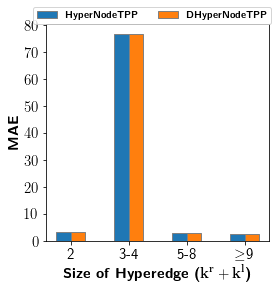

In [86]:
mae_undir_mean, mae_undir_std = np.mean(mae_undir,axis =0) , np.std(mae_undir, axis = 0)
mae_dir_mean, mae_dir_std = np.mean(mae_dir,axis =0) , np.std(mae_dir, axis = 0)

barWidth = 0.25
fig = plt.subplots(figsize =(4, 4))
x1 = np.arange(mae_undir_mean.shape[0])
x2 = [x + barWidth for x in x1]
 
# Make the plot
plt.bar(x1, mae_undir_mean, yerr= mae_undir_std, width = barWidth,
        edgecolor ='grey', label =r'\textbf{HyperNodeTPP}')
plt.bar(x2, mae_dir_mean, yerr= mae_dir_std, width = barWidth,
        edgecolor ='grey', label =r"\textbf{DHyperNodeTPP}")

# plt.xticks(np.array(x1)+barWidth/2, x1)
plt.xticks([r + barWidth/2 for r in range(len(x1))],
        [r'2', r'3-4', r'5-8', r'$\geq$9'], fontweight ='bold', fontsize = 15)
legend_properties = {'weight':'bold'}
plt.legend(prop=legend_properties, ncol = 2, loc=[-0.06,1])
plt.xlabel(r'\textbf{Size of Hyperedge ($\mathbf{k^r + k^l}$)}', fontsize = 15)
plt.ylabel(r'\textbf{MAE}', fontsize = 15)
plt.yticks(fontweight ='bold',fontsize= 15)
pathlib.Path(f"./Plots/{files[arg['fileID']]}").mkdir(parents=True,exist_ok=True)
plt.savefig(f"./Plots/{files[arg['fileID']]}/mae.pdf",bbox_inches='tight', dpi = 1000, pad_inches=0)
plt.show()

## Twitter

In [87]:
## Twitter
arg ={}
arg['fileID'] = 4  ## Enter dataset ID here 
arg['onlyleft'] = True ## If only left side is consider in directed dataset
valid_folders = [files[arg['fileID']]+"_alpha0.3seed"+str(i) for i in range(4)] + [files[arg['fileID']]+"_dir_alpha0.3seed"+str(i) for i in range(4)]
subpath =  os.path.join(resultpath,files[arg['fileID']])
for folder in os.listdir(subpath):
    if folder in valid_folders:
        for file in os.listdir(os.path.join(subpath,folder)):
           if  file.endswith('test.csv') or file.endswith('test.txt'): arg[folder+'_test'] = file


In [88]:
mrr_undir , mrr_dir , mae_undir, mae_dir = [],[],[],[]
for seed in range(4):
    for folder in valid_folders:
        if 'seed'+str(seed) in folder:
            if 'dir' in folder:
                print(f'\n********************* Directed || Seed {seed} *****************************')
                test_iterator = Iterator(os.path.join(subpath,folder,arg[folder+"_test"]))
                result = get_size_ablation(test_iterator)
                mrr_dir.append(result[0])
                mae_dir.append(result[1])
            else:
                print(f'\n********************* Undirected || Seed {seed} *****************************')
                test_iterator = Iterator(os.path.join(subpath,folder,arg[folder+"_test"]))
                result = get_size_ablation(test_iterator)
                mrr_undir.append(result[0])
                mae_undir.append(result[1])



********************* Undirected || Seed 0 *****************************
[1743, 615, 167, 33]
mean mrr for size [0,1,2,3] is [0.8429880449126249, 0.8202362096770023, 0.8581138480744676, 0.7687480874133833]
mean mae for size [0,1,2,3] is [1.1728128772560236, 1.1747676866113896, 1.18793825181703, 1.4621549433831014]

********************* Directed || Seed 0 *****************************
[1743, 615, 167, 33]
mean mrr for size [0,1,2,3] is [0.7997366930013474, 0.8448531108597914, 0.9193945444763421, 0.813672439392769]
mean mae for size [0,1,2,3] is [1.2076856268936371, 1.2032495240855023, 1.2407449706942735, 1.4770247629194548]

********************* Undirected || Seed 1 *****************************
[1743, 615, 167, 33]
mean mrr for size [0,1,2,3] is [0.8554360415942527, 0.8284432790810015, 0.8474289521485746, 0.7434343440514622]
mean mae for size [0,1,2,3] is [1.1834818197438859, 1.1736053497038357, 1.1940381478094413, 1.4978915048819599]

********************* Directed || Seed 1 ******

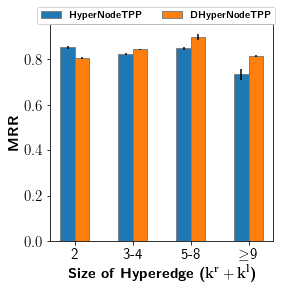

In [89]:
mrr_undir_mean, mrr_undir_std = np.mean(mrr_undir,axis =0) , np.std(mrr_undir, axis = 0)
mrr_dir_mean, mrr_dir_std = np.mean(mrr_dir,axis =0) , np.std(mrr_dir, axis = 0)
barWidth = 0.25
fig = plt.subplots(figsize =(4, 4))
x1 = np.arange(mrr_undir_mean.shape[0])
x2 = [x + barWidth for x in x1]
 
# Make the plot
plt.bar(x1, mrr_undir_mean, yerr= mrr_undir_std, width = barWidth,
        edgecolor ='grey', label =r'\textbf{HyperNodeTPP}')
plt.bar(x2, mrr_dir_mean, yerr= mrr_dir_std, width = barWidth,
        edgecolor ='grey', label =r'\textbf{DHyperNodeTPP}')

plt.xticks([r + barWidth/2 for r in range(len(x1))],
        [r'2', r'3-4', r'5-8', r'$\geq$9'], fontweight ='bold',fontsize = 15)
legend_properties = {'weight':'bold'}
plt.legend(prop=legend_properties, ncol = 2, loc=[-0.06,1])
plt.xlabel(r'\textbf{Size of Hyperedge ($\mathbf{k^r + k^l}$)}',fontsize = 15)
plt.ylabel(r'\textbf{MRR}',fontsize = 15)
plt.yticks(fontweight ='bold',fontsize = 15)
pathlib.Path(f"./Plots/{files[arg['fileID']]}").mkdir(parents=True,exist_ok=True)
plt.savefig(f"./Plots/{files[arg['fileID']]}/mrr.pdf",bbox_inches='tight', dpi = 1000, pad_inches=0)
plt.show()



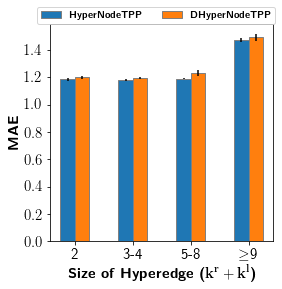

In [90]:
mae_undir_mean, mae_undir_std = np.mean(mae_undir,axis =0) , np.std(mae_undir, axis = 0)
mae_dir_mean, mae_dir_std = np.mean(mae_dir,axis =0) , np.std(mae_dir, axis = 0)

barWidth = 0.25
fig = plt.subplots(figsize =(4, 4))
x1 = np.arange(mae_undir_mean.shape[0])
x2 = [x + barWidth for x in x1]
 
# Make the plot
plt.bar(x1, mae_undir_mean, yerr= mae_undir_std, width = barWidth,
        edgecolor ='grey', label =r'\textbf{HyperNodeTPP}')
plt.bar(x2, mae_dir_mean, yerr= mae_dir_std, width = barWidth,
        edgecolor ='grey', label =r"\textbf{DHyperNodeTPP}")

# plt.xticks(np.array(x1)+barWidth/2, x1)
plt.xticks([r + barWidth/2 for r in range(len(x1))],
        [r'2', r'3-4', r'5-8', r'$\geq$9'], fontweight ='bold', fontsize = 15)
legend_properties = {'weight':'bold'}
plt.legend(prop=legend_properties, ncol = 2, loc=[-0.06,1])
plt.xlabel(r'\textbf{Size of Hyperedge ($\mathbf{k^r + k^l}$)}', fontsize = 15)
plt.ylabel(r'\textbf{MAE}', fontsize = 15)
plt.yticks(fontweight ='bold',fontsize= 15)
pathlib.Path(f"./Plots/{files[arg['fileID']]}").mkdir(parents=True,exist_ok=True)
plt.savefig(f"./Plots/{files[arg['fileID']]}/mae.pdf",bbox_inches='tight', dpi = 1000, pad_inches=0)
plt.show()

## Hepth

In [91]:
## hepth
arg ={}
arg['fileID'] = 2  ## Enter dataset ID here 
arg['onlyleft'] = False ## If only left side is consider in directed dataset, the flag is true.
valid_folders = [files[arg['fileID']]+"_alpha0.3seed"+str(i)+'_1e-3' for i in range(3)] + [files[arg['fileID']]+"_dir_alpha0.3seed"+str(i)+'_1e-3'  for i in range(3)]
subpath =  os.path.join(resultpath,files[arg['fileID']])
for folder in os.listdir(subpath):
    if folder in valid_folders:
        for file in os.listdir(os.path.join(subpath,folder)):
            if  file.endswith('test.csv') or file.endswith('test.txt'): arg[folder+'_test'] = file

In [92]:
mrr_undir , mrr_dir , mae_undir, mae_dir = [],[],[],[]
for seed in range(4):
    for folder in valid_folders:
        if 'seed'+str(seed) in folder:
            if 'dir' in folder:
                print(f'\n********************* Directed || Seed {seed} *****************************')
                test_iterator = Iterator(os.path.join(subpath,folder,arg[folder+"_test"]))
                result = get_size_ablation(test_iterator)
                mrr_dir.append(result[0])
                mae_dir.append(result[1])
            else:
                print(f'\n********************* Undirected || Seed {seed} *****************************')
                test_iterator = Iterator(os.path.join(subpath,folder,arg[folder+"_test"]))
                result = get_size_ablation(test_iterator)
                mrr_undir.append(result[0])
                mae_undir.append(result[1])



********************* Undirected || Seed 0 *****************************
[137, 224, 495, 1704]
mean mrr for size [0,1,2,3] is [0.7937401417289337, 0.5547586856077292, 0.44853128232438155, 0.42123032469267435]
mean mae for size [0,1,2,3] is [1.2459152196907866, 1.1639293323137931, 1.2839781199252667, 1.2572618968262306]

********************* Directed || Seed 0 *****************************
[137, 224, 495, 1704]
mean mrr for size [0,1,2,3] is [0.8415420309633669, 0.7579802337401945, 0.7241651482353306, 0.5975568012548654]
mean mae for size [0,1,2,3] is [1.2860773674409538, 1.2147154633754067, 1.3377073493757934, 1.2747050144571916]

********************* Undirected || Seed 1 *****************************
[137, 224, 495, 1704]
mean mrr for size [0,1,2,3] is [0.8469475783462072, 0.5777383372021306, 0.4578953058280126, 0.3706354472322713]
mean mae for size [0,1,2,3] is [1.2538014492631828, 1.1651396458245082, 1.2813431708085719, 1.2583402765121205]

********************* Directed || Seed 

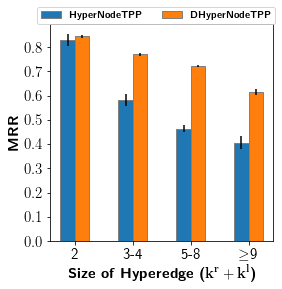

In [93]:
mrr_undir_mean, mrr_undir_std = np.mean(mrr_undir,axis =0) , np.std(mrr_undir, axis = 0)
mrr_dir_mean, mrr_dir_std = np.mean(mrr_dir,axis =0) , np.std(mrr_dir, axis = 0)
barWidth = 0.25
fig = plt.subplots(figsize =(4, 4))
x1 = np.arange(mrr_undir_mean.shape[0])
x2 = [x + barWidth for x in x1]
 
# Make the plot
plt.bar(x1, mrr_undir_mean, yerr= mrr_undir_std, width = barWidth,
        edgecolor ='grey', label =r'\textbf{HyperNodeTPP}')
plt.bar(x2, mrr_dir_mean, yerr= mrr_dir_std, width = barWidth,
        edgecolor ='grey', label =r'\textbf{DHyperNodeTPP}')

plt.xticks([r + barWidth/2 for r in range(len(x1))],
        [r'2', r'3-4', r'5-8', r'$\geq$9'], fontweight ='bold',fontsize = 15)
legend_properties = {'weight':'bold'}
plt.legend(prop=legend_properties, ncol = 2, loc=[-0.06,1])
plt.xlabel(r'\textbf{Size of Hyperedge ($\mathbf{k^r + k^l}$)}',fontsize = 15)
plt.ylabel(r'\textbf{MRR}',fontsize = 15)
plt.yticks(fontweight ='bold',fontsize = 15)
pathlib.Path(f"./Plots/{files[arg['fileID']]}").mkdir(parents=True,exist_ok=True)
plt.savefig(f"./Plots/{files[arg['fileID']]}/mrr.pdf",bbox_inches='tight', dpi = 1000, pad_inches=0)
plt.show()



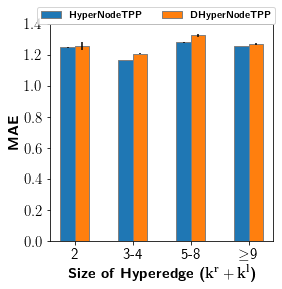

In [94]:
mae_undir_mean, mae_undir_std = np.mean(mae_undir,axis =0) , np.std(mae_undir, axis = 0)
mae_dir_mean, mae_dir_std = np.mean(mae_dir,axis =0) , np.std(mae_dir, axis = 0)

barWidth = 0.25
fig = plt.subplots(figsize =(4, 4))
x1 = np.arange(mae_undir_mean.shape[0])
x2 = [x + barWidth for x in x1]
 
# Make the plot
plt.bar(x1, mae_undir_mean, yerr= mae_undir_std, width = barWidth,
        edgecolor ='grey', label =r'\textbf{HyperNodeTPP}')
plt.bar(x2, mae_dir_mean, yerr= mae_dir_std, width = barWidth,
        edgecolor ='grey', label =r"\textbf{DHyperNodeTPP}")

# plt.xticks(np.array(x1)+barWidth/2, x1)
plt.xticks([r + barWidth/2 for r in range(len(x1))],
        [r'2', r'3-4', r'5-8', r'$\geq$9'], fontweight ='bold', fontsize = 15)
legend_properties = {'weight':'bold'}
plt.legend(prop=legend_properties, ncol = 2, loc=[-0.06,1])
plt.xlabel(r'\textbf{Size of Hyperedge ($\mathbf{k^r + k^l}$)}', fontsize = 15)
plt.ylabel(r'\textbf{MAE}', fontsize = 15)
plt.yticks(fontweight ='bold',fontsize= 15)
pathlib.Path(f"./Plots/{files[arg['fileID']]}").mkdir(parents=True,exist_ok=True)
plt.savefig(f"./Plots/{files[arg['fileID']]}/mae.pdf",bbox_inches='tight', dpi = 1000, pad_inches=0)
plt.show()

## arxiv

In [95]:
## arxiv
arg ={}
arg['fileID'] = 3   ## Enter dataset ID here 
arg['onlyleft'] = False ## If only left side is consider in directed dataset
valid_folders = [files[arg['fileID']]+"_alpha0.3seed"+str(i)+'_1e-3' for i in range(3)] + [files[arg['fileID']]+"_dir_alpha0.3seed"+str(i)+'_1e-3' for i in range(3)]
subpath =  os.path.join(resultpath,files[arg['fileID']])
for folder in os.listdir(subpath):
    if folder in valid_folders:
        for file in os.listdir(os.path.join(subpath,folder)):
           if  file.endswith('test.csv') or file.endswith('test.txt'): arg[folder+'_test'] = file

In [96]:
mrr_undir , mrr_dir , mae_undir, mae_dir = [],[],[],[]
for seed in range(4):
    for folder in valid_folders:
        if 'seed'+str(seed) in folder:
            if 'dir' in folder:
                print(f'\n********************* Directed || Seed {seed} *****************************')
                test_iterator = Iterator(os.path.join(subpath,folder,arg[folder+"_test"]))
                result = get_size_ablation(test_iterator)
                mrr_dir.append(result[0])
                mae_dir.append(result[1])
            else:
                print(f'\n********************* Undirected || Seed {seed} *****************************')
                test_iterator = Iterator(os.path.join(subpath,folder,arg[folder+"_test"]))
                result = get_size_ablation(test_iterator)
                mrr_undir.append(result[0])
                mae_undir.append(result[1])



********************* Undirected || Seed 0 *****************************
[173, 421, 859, 3155]
mean mrr for size [0,1,2,3] is [0.34438064011793607, 0.28672858293117365, 0.26435257774605325, 0.2969220305502226]
mean mae for size [0,1,2,3] is [1.0904957081024358, 0.9650618251337894, 1.0506039940306486, 0.9823227765159637]

********************* Directed || Seed 0 *****************************
[173, 421, 859, 3155]
mean mrr for size [0,1,2,3] is [0.45017988015116983, 0.4716262776767415, 0.43104546538383914, 0.4692179234724982]
mean mae for size [0,1,2,3] is [1.0770056437205717, 0.9963221267184282, 1.0557584542178302, 0.9833176027859447]

********************* Undirected || Seed 1 *****************************
[173, 421, 859, 3155]
mean mrr for size [0,1,2,3] is [0.29880736133008334, 0.2879804697799145, 0.2675053745430132, 0.2977684174624468]
mean mae for size [0,1,2,3] is [1.0830393208761435, 0.9677874407600479, 1.042427352500583, 0.9802021971075735]

********************* Directed || Se

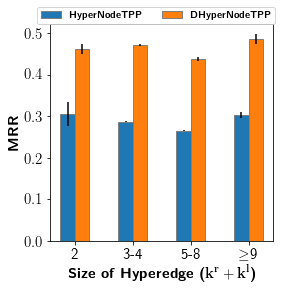

In [97]:
mrr_undir_mean, mrr_undir_std = np.mean(mrr_undir,axis =0) , np.std(mrr_undir, axis = 0)
mrr_dir_mean, mrr_dir_std = np.mean(mrr_dir,axis =0) , np.std(mrr_dir, axis = 0)
barWidth = 0.25
fig = plt.subplots(figsize =(4, 4))
x1 = np.arange(mrr_undir_mean.shape[0])
x2 = [x + barWidth for x in x1]
 
# Make the plot
plt.bar(x1, mrr_undir_mean, yerr= mrr_undir_std, width = barWidth,
        edgecolor ='grey', label =r'\textbf{HyperNodeTPP}')
plt.bar(x2, mrr_dir_mean, yerr= mrr_dir_std, width = barWidth,
        edgecolor ='grey', label =r'\textbf{DHyperNodeTPP}')

plt.xticks([r + barWidth/2 for r in range(len(x1))],
        [r'2', r'3-4', r'5-8', r'$\geq$9'], fontweight ='bold',fontsize = 15)
legend_properties = {'weight':'bold'}
plt.legend(prop=legend_properties, ncol = 2, loc=[-0.06,1])
plt.xlabel(r'\textbf{Size of Hyperedge ($\mathbf{k^r + k^l}$)}',fontsize = 15)
plt.ylabel(r'\textbf{MRR}',fontsize = 15)
plt.yticks(fontweight ='bold',fontsize = 15)
pathlib.Path(f"./Plots/{files[arg['fileID']]}").mkdir(parents=True,exist_ok=True)
plt.savefig(f"./Plots/{files[arg['fileID']]}/mrr.pdf",bbox_inches='tight', dpi = 1000, pad_inches=0)
plt.show()



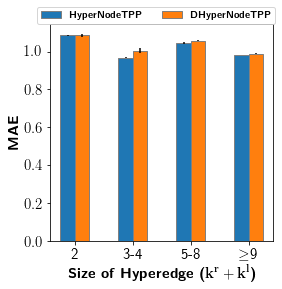

In [98]:
mae_undir_mean, mae_undir_std = np.mean(mae_undir,axis =0) , np.std(mae_undir, axis = 0)
mae_dir_mean, mae_dir_std = np.mean(mae_dir,axis =0) , np.std(mae_dir, axis = 0)

barWidth = 0.25
fig = plt.subplots(figsize =(4, 4))
x1 = np.arange(mae_undir_mean.shape[0])
x2 = [x + barWidth for x in x1]
 
# Make the plot
plt.bar(x1, mae_undir_mean, yerr= mae_undir_std, width = barWidth,
        edgecolor ='grey', label =r'\textbf{HyperNodeTPP}')
plt.bar(x2, mae_dir_mean, yerr= mae_dir_std, width = barWidth,
        edgecolor ='grey', label =r"\textbf{DHyperNodeTPP}")

# plt.xticks(np.array(x1)+barWidth/2, x1)
plt.xticks([r + barWidth/2 for r in range(len(x1))],
        [r'2', r'3-4', r'5-8', r'$\geq$9'], fontweight ='bold', fontsize = 15)
legend_properties = {'weight':'bold'}
plt.legend(prop=legend_properties, ncol = 2, loc=[-0.06,1])
plt.xlabel(r'\textbf{Size of Hyperedge ($\mathbf{k^r + k^l}$)}', fontsize = 15)
plt.ylabel(r'\textbf{MAE}', fontsize = 15)
plt.yticks(fontweight ='bold',fontsize= 15)
pathlib.Path(f"./Plots/{files[arg['fileID']]}").mkdir(parents=True,exist_ok=True)
plt.savefig(f"./Plots/{files[arg['fileID']]}/mae.pdf",bbox_inches='tight', dpi = 1000, pad_inches=0)
plt.show()

## SIZE AUC PLOT

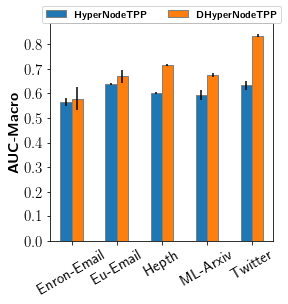

In [44]:
files = ['Enron-Email', 'Eu-Email', 'Hepth', 'ML-Arxiv', 'Twitter']
size_ovr_macro_undir_mean = [0.56473907,0.639701, 0.60047175, 0.5931605, 0.63288225]
size_ovr_macro_undir_std = [0.01699041, 0.003585001, 0.004066293, 0.021689696, 0.018652199 ]
size_ovr_macro_dir_mean = [0.578432424, 0.669392333, 0.71519375, 0.67425825, 0.83602225]
size_ovr_macro_dir_std =[0.046065349, 0.027948615, 0.003275947, 0.007731285, 0.007626184]

barWidth = 0.25
fig = plt.subplots(figsize =(4, 4))
x1 = np.arange(len(files))
x2 = [x + barWidth for x in x1]
 
# Make the plot
plt.bar(x1, size_ovr_macro_undir_mean, yerr= size_ovr_macro_undir_std, width = barWidth,
        edgecolor ='grey', label =r'\textbf{HyperNodeTPP}')
plt.bar(x2, size_ovr_macro_dir_mean, yerr= size_ovr_macro_dir_std, width = barWidth,
        edgecolor ='grey', label =r'\textbf{DHyperNodeTPP}')

plt.xticks([r + barWidth/2 for r in range(len(x1))],
        files, fontweight ='bold',rotation = 30, fontsize = 15)
legend_properties = {'weight':'bold'}
plt.legend(prop=legend_properties, ncol = 2, loc=[-0.035,1])
plt.ylabel(r'\textbf{AUC-Macro}', fontsize = 15)
plt.yticks(fontweight ='bold', fontsize = 15)
pathlib.Path(f"./Plots/").mkdir(parents=True,exist_ok=True)
plt.savefig(f"./Plots/size_auc_ovr_macro.pdf",bbox_inches='tight', dpi = 1000, pad_inches=0)
plt.show()

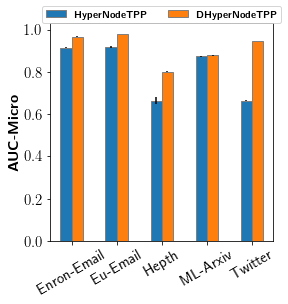

In [45]:
size_ovr_micro_undir_mean = [0.915937363,0.919895, 0.66333425, 0.87447175, 0.66333425]
size_ovr_micro_undir_std = [0.001477484, 0.004046901, 0.017296771, 0.00101608, 0.003015756 ]
size_ovr_micro_dir_mean = [0.967182343, 0.981192, 0.800721, 0.8799245, 0.94755675]
size_ovr_micro_dir_std =[0.001236461, 0.000573192, 0.001755684, 0.001762374, 0.001214482]

barWidth = 0.25
fig = plt.subplots(figsize =(4, 4))
x1 = np.arange(len(files))
x2 = [x + barWidth for x in x1]
 
# Make the plot
plt.bar(x1, size_ovr_micro_undir_mean, yerr= size_ovr_micro_undir_std, width = barWidth,
        edgecolor ='grey', label =r'\textbf{HyperNodeTPP}')
plt.bar(x2, size_ovr_micro_dir_mean, yerr= size_ovr_micro_dir_std, width = barWidth,
        edgecolor ='grey', label =r'\textbf{DHyperNodeTPP}')
plt.xticks([r + barWidth/2 for r in range(len(x1))],
        files, fontweight ='bold',rotation = 30, fontsize = 15)
legend_properties = {'weight':'bold'}
plt.legend(prop=legend_properties, ncol = 2, loc=[-0.035,1])
plt.ylabel(r'\textbf{AUC-Micro}', fontsize = 15)
plt.yticks(fontweight ='bold', fontsize = 15)

pathlib.Path(f"./Plots/").mkdir(parents=True,exist_ok=True)
plt.savefig(f"./Plots/size_auc_ovr_micro.pdf",bbox_inches='tight', dpi = 500, pad_inches=0)
plt.show()

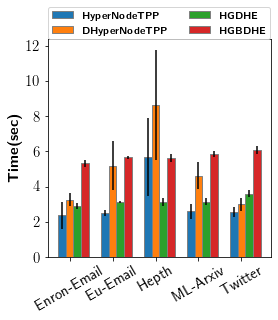

In [46]:
### Plotting  Time 
## OUR MODEL
size_ovr_micro_undir_mean = [2.3597, 2.508101325, 5.695910548, 2.580070827, 2.5778881]
size_ovr_micro_undir_std = [0.7632, 0.183929777, 2.228883686, 0.454268633, 0.28474176 ]
size_ovr_micro_dir_mean = [3.2620181215220483, 5.197882716, 8.670453479, 4.626798868, 2.988068932]
size_ovr_micro_dir_std =[0.36234001986054987, 1.410137911, 3.129809754, 0.751714422, 0.376469224]

## HGDHE - HGBDHE
size_ovr_micro_undir_mean1 = [2.909767220760214, 3.118877832547273, 3.1242078695541773, 3.1340121957990856, 3.590806934568617]
size_ovr_micro_undir_std1 = [0.16950381721862082, 0.06274417695836622, 0.21531041494741357,0.19177928263871086 , 0.2106653311514322 ]
size_ovr_micro_dir_mean1 = [5.328568585987749, 5.664541361060473, 5.642748851042527, 5.863540341456731, 6.084951122601827]
size_ovr_micro_dir_std1 =[0.18556093825235265, 0.07157830632360304, 0.23261645288861316, 0.18142494277780324, 0.21849653613827758]


barWidth = 0.18
fig = plt.subplots(figsize =(4, 4))
x1 = np.arange(len(files))
x2 = [x + barWidth for x in x1]
x3 = [x + barWidth for x in x2]
x4 = [x + barWidth for x in x3]
 
# Make the plot
plt.bar(x1, size_ovr_micro_undir_mean, yerr= size_ovr_micro_undir_std, width = barWidth,
        edgecolor ='grey', label =r'\textbf{HyperNodeTPP}')
plt.bar(x2, size_ovr_micro_dir_mean, yerr= size_ovr_micro_dir_std, width = barWidth,
        edgecolor ='grey', label =r'\textbf{DHyperNodeTPP}')

plt.bar(x3, size_ovr_micro_undir_mean1, yerr= size_ovr_micro_undir_std1, width = barWidth,
        edgecolor ='grey', label =r'\textbf{HGDHE}')
plt.bar(x4, size_ovr_micro_dir_mean1, yerr= size_ovr_micro_dir_std1, width = barWidth,
        edgecolor ='grey', label =r'\textbf{HGBDHE}')

plt.xticks([r + barWidth for r in range(len(x1))],
        files, fontweight ='bold',rotation = 30, fontsize = 15)
legend_properties = {'weight':'bold', 'size' :10.6}
plt.legend(prop=legend_properties, ncol = 2, loc=[0,1])
plt.ylabel(r'\textbf{Time(sec)}', fontsize = 15)
plt.yticks(fontweight ='bold', fontsize = 15)

pathlib.Path(f"./Plots/").mkdir(parents=True,exist_ok=True)
plt.savefig(f"./Plots/time.pdf",bbox_inches='tight', dpi = 500, pad_inches=0)
plt.show()